<a href="https://colab.research.google.com/github/ngzhankang/Deep-Learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Submitted by : P1935727 Ng Zhan Kang<br>
Class of DIT/FT/2B/11


---

---

# Index
1. [Setting Up Working Environment In Google Colab](#Setting-Up-Working-Environment-In-Google-Colab)

---

---

# Setting Up Working Environment In Google Colab

### 1. Ensuring 0% Util

---

Ensure that our slot give by Google is not utilized yet.

In [ ]:
# to ensure that the current gpu utilization is 0
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=a99c70faea5717655a722412518773fd0761a10fbfdf4e1658d3feecda0be054
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 165.2 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


### 2. Forcing Utils To 0%

---

Please do not use this step unless forced to.

In [ ]:
# if utilization is > 0, run this code(keep running this cell and the above cell till the util number is 0%):
# NOTE THAT RUNNING THIS MIGHT KILL GPU SESSION AND RESULT IN DATA LOSS(NOT ADVICABLE TO KEEP ON REUSING)
# !kill -9 -1

---

---

# About The MNIST Dataset (Background Information)

- BACKGROUND
    - The MNIST database(Modified National Institute of Standards and Technology database) history came to existence by 
    - The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

## Classic MNIST Dataset
- For this problem, use only 1 target output variable (Survived)
- Prepare the data and perform necessary feature engineering
- Create **_at least two models_** 
- Evaluate the models and pick the best candidate
- Form some conclusions

---

---

# Data Importing

### 1. Load the libraries

---

Import the necessary libraries.

In [ ]:
# Suppress Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# check versions of libraries we are going to use
%tensorflow_version 2.x
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Tensorflow version={}".format(tensorflow.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Tensorflow version=2.3.0
Numpy version=1.18.5
Pandas version=1.1.2
Seaborn version=0.11.0
Matplotlib version=3.2.2
Python version=3.6.9


In [ ]:
# start importing necessary libraries
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [ ]:
# get the dataset from keras library in tensorflow 2.0
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### 2. Data Exploration

---

Take a peek look at what is inside the train_images and the test_images.

In [ ]:
# take a look at the train_images set first
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [ ]:
# take a look at the test_images set
print(test_images.shape)
print(test_labels.shape)

(10000, 28, 28)
(10000,)


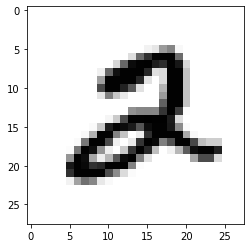

In [ ]:
# grab a random picture to take a look
plt.imshow(train_images[5], cmap=plt.cm.binary)
plt.show()

In [ ]:
# get the distinct lables that are found in the entire thing
print('Training set unique labels:',np.unique(train_labels))
print('Test set unique labels:',np.unique(test_labels))

Training set unique labels: [0 1 2 3 4 5 6 7 8 9]
Test set unique labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# get the count of the values from 0 to 9
unique, counts = np.unique(train_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]
